# Matrix Multiplication
:label:`ch_matmul_cpu`

We saw the NumPy `dot` operator nearly reaches the peak performance of our CPU (the Xeon E5-2686 v4) in :numref:`ch_cpu_arch`. In this section, we will investigate multiple scheduling strategies for this operator in TVM.

## Setup


In [1]:
%matplotlib inline
import d2ltvm
import numpy as np
import timeit
import tvm
from tvm import te

# target = 'llvm -mcpu=skylake-avx512'
target = 'llvm'

As we did in :numref:`ch_vector_add_cpu`, we first define a method to measure NumPy performance as our baseline.


In [2]:
# Save to the d2ltvm package.
def np_matmul_timer(n):
    timer = timeit.Timer(setup='import numpy as np\n'
                         'import d2ltvm\n'
                         'a, b, c = d2ltvm.get_abc(%s)' % str((n,n)),
                         stmt = 'np.dot(a, b, out=c)')
    return timer.timeit

sizes = 2**np.arange(5, 12, 1)
exe_times = [d2ltvm.bench_workload(np_matmul_timer(n)) for n in sizes]
np_gflops = 2 * sizes **3 / 1e9 / np.array(exe_times)

## Default Schedule

The default schedule consists of three nested for-loops.


In [3]:
def default(n):
    A, B, C = d2ltvm.matmul(n, n, n)
    return te.create_schedule(C.op), (A, B, C)

s, args = default(64)
print(tvm.lower(s, args, simple_mode=True))

# from tvm.script import ir as I
# from tvm.script import tir as T

@I.ir_module
class Module:
    @T.prim_func
    def main(A: T.Buffer((64, 64), "float32"), B: T.Buffer((64, 64), "float32"), T_matmul: T.Buffer((64, 64), "float32")):
        T.func_attr({"from_legacy_te_schedule": T.bool(True), "tir.noalias": T.bool(True)})
        for ax0, ax1 in T.grid(64, 64):
            T_matmul_1 = T.Buffer((4096,), data=T_matmul.data)
            T_matmul_1[ax0 * 64 + ax1] = T.float32(0.0)
            for k in range(64):
                cse_var_2: T.int32 = ax0 * 64
                cse_var_1: T.int32 = cse_var_2 + ax1
                A_1 = T.Buffer((4096,), data=A.data)
                B_1 = T.Buffer((4096,), data=B.data)
                T_matmul_1[cse_var_1] = T_matmul_1[cse_var_1] + A_1[cse_var_2 + k] * B_1[k * 64 + ax1]


To benchmark its performance, we also define a reusable method as we did in :numref:`ch_vector_add_cpu`.


In [4]:
# Save to the d2ltvm package.
def bench_matmul_tvm(func, sizes, target):
    def workload(nrepeats):
        timer = mod.time_evaluator(mod.entry_name, dev=ctx, number=nrepeats)
        return timer(a, b, c).mean * nrepeats
    times = []
    for n in sizes:
        s, (A, B, C) = func(int(n))
        mod = tvm.build(s, [A, B, C], target)
        ctx = tvm.device(target, 0)
        a, b, c = d2ltvm.get_abc((n, n), lambda x: tvm.nd.array(x, device=ctx))
        times.append(d2ltvm.bench_workload(workload))
    return 2 * sizes**3 / 1e9 / np.array(times)

The default schedule follows the computation illustrated in :numref:`fig_matmul_default`.
It's not surprising to see that the default schedule doesn't perform well, especially for large matrices that cannot fit into the cache.


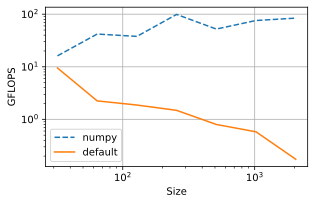

In [5]:
default_gflops = bench_matmul_tvm(default, sizes, target)
d2ltvm.plot_gflops(sizes, [np_gflops, default_gflops], ['numpy', 'default'])

## Reordering Axes

The first problem we can see from :numref:`fig_matmul_default` is that matrix $B$ is accessed column by column while its elements are stored by rows (i.e. matrix $B$ is in [row-major](https://en.wikipedia.org/wiki/Row-_and_column-major_order)). In other words, in the pseudo code above, we iterate axis `y` before axis `k`. Simply switching these two for-loops will make all elements read and written sequentially. :numref:`fig_matmul_reorder` illustrates the changed the data access pattern.

![Reorder axes in matrix multiplication.](../img/matmul_reorder.svg)
:label:`fig_matmul_reorder`

To implement it, we change the axes order from (`x`, `y`, `k`) to (`x`, `k`, `y`) by the `reorder` primitive. The corresponding pseudo code verifies that we are processing all matrices row by row now.


In [6]:
def reorder(n):
    s, (A, B, C) = default(n)
    (x, y), (k,) = C.op.axis, C.op.reduce_axis
    s[C].reorder(x, k, y)
    return s, (A, B, C)

s, args = reorder(64)
print(tvm.lower(s, args, simple_mode=True))

# from tvm.script import ir as I
# from tvm.script import tir as T

@I.ir_module
class Module:
    @T.prim_func
    def main(A: T.Buffer((64, 64), "float32"), B: T.Buffer((64, 64), "float32"), T_matmul: T.Buffer((64, 64), "float32")):
        T.func_attr({"from_legacy_te_schedule": T.bool(True), "tir.noalias": T.bool(True)})
        for ax0 in range(64):
            T_matmul_1 = T.Buffer((4096,), data=T_matmul.data)
            for ax1_init in range(64):
                T_matmul_1[ax0 * 64 + ax1_init] = T.float32(0.0)
            for k, ax1 in T.grid(64, 64):
                cse_var_2: T.int32 = ax0 * 64
                cse_var_1: T.int32 = cse_var_2 + ax1
                A_1 = T.Buffer((4096,), data=A.data)
                B_1 = T.Buffer((4096,), data=B.data)
                T_matmul_1[cse_var_1] = T_matmul_1[cse_var_1] + A_1[cse_var_2 + k] * B_1[k * 64 + ax1]


We can see that the reordering significantly improves the performance compared to the default schedule.


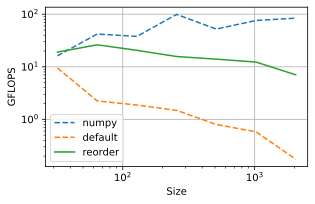

In [7]:
reorder_gflops = bench_matmul_tvm(reorder, sizes, target)
d2ltvm.plot_gflops(sizes, [np_gflops, default_gflops, reorder_gflops],
            ['numpy', 'default', 'reorder'])

## Parallelization

Let's revisit the pseudo code above. In the outermost for-loop `for (x, 0, 64)`, each time we compute the results of a row in $C$. Each row can be computed in parallel, so we can make the schedule parallelize axis `x`.


In [8]:
def parallel(n):
    s, (A, B, C) = reorder(n)
    s[C].parallel(C.op.axis[0])
    return s, (A, B, C)

s, args = parallel(64)
print(tvm.lower(s, args, simple_mode=True))

# from tvm.script import ir as I
# from tvm.script import tir as T

@I.ir_module
class Module:
    @T.prim_func
    def main(A: T.Buffer((64, 64), "float32"), B: T.Buffer((64, 64), "float32"), T_matmul: T.Buffer((64, 64), "float32")):
        T.func_attr({"from_legacy_te_schedule": T.bool(True), "tir.noalias": T.bool(True)})
        for ax0 in T.parallel(64):
            T_matmul_1 = T.Buffer((4096,), data=T_matmul.data)
            for ax1_init in range(64):
                T_matmul_1[ax0 * 64 + ax1_init] = T.float32(0.0)
            for k, ax1 in T.grid(64, 64):
                cse_var_2: T.int32 = ax0 * 64
                cse_var_1: T.int32 = cse_var_2 + ax1
                A_1 = T.Buffer((4096,), data=A.data)
                B_1 = T.Buffer((4096,), data=B.data)
                T_matmul_1[cse_var_1] = T_matmul_1[cse_var_1] + A_1[cse_var_2 + k] * B_1[k * 64 + ax1]


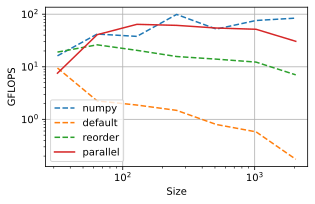

In [9]:
parallel_gflops = bench_matmul_tvm(parallel, sizes, target)
d2ltvm.plot_gflops(sizes, [np_gflops, default_gflops, reorder_gflops, parallel_gflops],
            ['numpy', 'default', 'reorder', 'parallel'])

Parallelization improves the performance again. But we can see that there is still a gap compared to NumPy on large matrices, specially when they cannot fit into the L2 cache. We will try to resolve it in the next section.

## Summary

- Reordering the for-loops in matrix multiplication properly improves the performance.
- Proper thread-level parallelization also improves the performance.

## Exercises

1. Change the number of threads
1. Try to order the axes in method `parallel` differently
1. Benchmark matrix multiplication in larger sizes
